<a href="https://colab.research.google.com/github/MVijayKrishna/neolens_bame/blob/feature_random/Jaundice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving full_jaundice_metadata.csv to full_jaundice_metadata.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# === 1. Load and Prepare Data ===
df = pd.read_csv("full_jaundice_metadata.csv")

# Clean text
for col in df.columns:
    df[col] = df[col].astype(str).str.strip().str.lower().str.replace('â€”', '-', regex=False)

# Drop unused
df = df.drop(columns=["Image_ID", "File_Path", "Notes"])

# Encode target
df['Condition'] = df['Condition'].map({'normal': 0, 'jaundiced': 1})

# Label encode all features
X = df.drop(columns=['Condition']).copy()
y = df['Condition'].copy()

In [ ]:
y.value_counts()

,count
Condition,
1,110
0,110


In [ ]:
label_encoders = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # save encoder for future use

# === 2. KFold + SMOTE + XGBoost ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
all_y_true = []
all_y_pred = []

print("📊 XGBoost with Label Encoding and KFold + SMOTE:\n")

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale (optional but helps sometimes)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply SMOTE on training only
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # Train XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = model.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Report:")
    print(classification_report(y_test, y_pred))
    fold += 1

# === 3. Overall Report ===
print("📈 Final Classification Report (All Folds Combined):")
print(classification_report(all_y_true, all_y_pred))

📊 XGBoost with Label Encoding and KFold + SMOTE:

Fold 1 Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61        27
           1       0.48      0.71      0.57        17

    accuracy                           0.59        44
   macro avg       0.61      0.61      0.59        44
weighted avg       0.64      0.59      0.59        44

Fold 2 Report:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        18
           1       0.55      0.42      0.48        26

    accuracy                           0.45        44
   macro avg       0.46      0.46      0.45        44
weighted avg       0.48      0.45      0.46        44



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Report:
              precision    recall  f1-score   support

           0       0.37      0.65      0.47        17
           1       0.57      0.30      0.39        27

    accuracy                           0.43        44
   macro avg       0.47      0.47      0.43        44
weighted avg       0.49      0.43      0.42        44

Fold 4 Report:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        22
           1       0.52      0.55      0.53        22

    accuracy                           0.52        44
   macro avg       0.52      0.52      0.52        44
weighted avg       0.52      0.52      0.52        44

Fold 5 Report:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        26
           1       0.26      0.28      0.27        18

    accuracy                           0.39        44
   macro avg       0.37      0.37      0.37        44
weighted avg       0.39      

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import joblib

# Save model
joblib.dump(model, "xgboost_jaundice_model.pkl")

# Save scaler and label encoders too
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [ ]:
from google.colab import files

files.download("xgboost_jaundice_model.pkl")
files.download("scaler.pkl")
files.download("label_encoders.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

df = pd.read_csv("full_jaundice_metadata.csv")

X = df.drop(columns=["Condition"])
y = df["Condition"]


label_encoders = {}
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Save for future inverse_transform if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Before SMOTE: {'Jaundiced': 88, 'Normal': 88}
After SMOTE: {'Jaundiced': 88, 'Normal': 88}
Classification Report:
               precision    recall  f1-score   support

   Jaundiced       1.00      1.00      1.00        22
      Normal       1.00      1.00      1.00        22

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

Confusion Matrix:
 [[22  0]
 [ 0 22]]


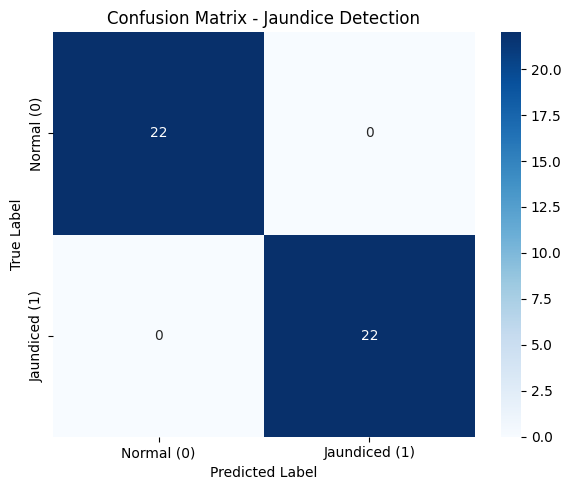

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Normal (0)', 'Jaundiced (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Jaundice Detection")
plt.tight_layout()
plt.show()


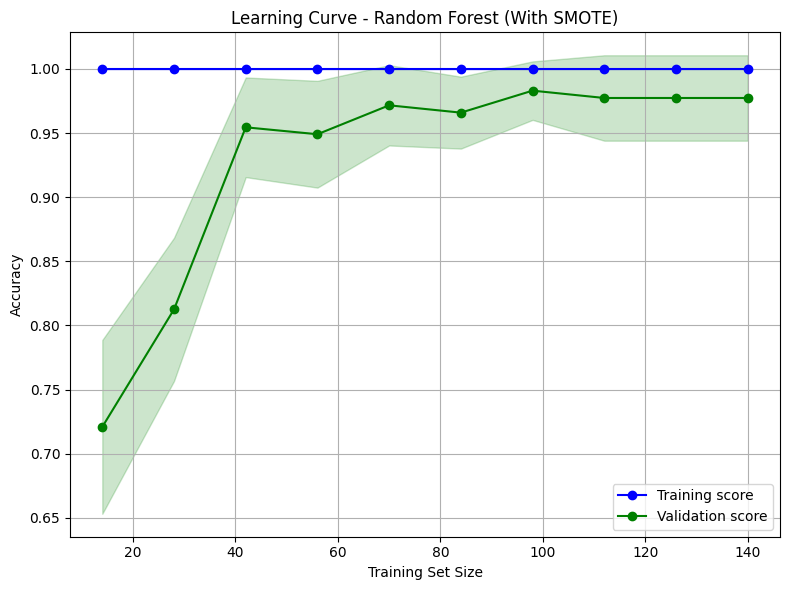

In [15]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train_resampled,
    y=y_train_resampled,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve - Random Forest (With SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
